# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells run and is stored in your team's [Github Classroom repository](https://classroom.github.com/a/CNxME27U). You will also need to write a short, 2 page report about your design decisions as a team, to be stored in your repository. The Milestone 4 submission will be the contents of your repository at the due date (April 28 at 23:59 CET).

## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.

Lernnavi's dataset is formatted in three main tables:
* ***users***: demographic information of users.
* ***events***: events done by the users in the platform.
* ***transactions***: question and answer solved by user.

These table are described in detail in the [Milestone 2 data exploration notebook](https://github.com/epfl-ml4ed/mlbd-2023/blob/main/project/milestone-02/m2_lernnavi_sciper.ipynb). We have also provided access to a [test account to experiment with Lernnavi](https://moodle.epfl.ch/mod/forum/discuss.php?d=88094). 

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, silhouette_score, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import kneed
from kneed import KneeLocator
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

DATA_DIR = './../data' # You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))
topics_translated = pd.read_csv('{}/topics_translated.csv'.format(DATA_DIR))
documents = pd.read_csv('{}/documents.csv.gz'.format(DATA_DIR))

## Task 0: Research Question

We are going to evaluate what we call the user catchability. Thus, predict what's the probability for a user to return on the application after his first 10 sessions.

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task. We choose our features by looking to the different papers we got.

### Data Cleaning

In [2]:
m4_users = users.copy()

In [3]:
#change column event_date to date_time
m4_events = events.copy()
m4_events['event_date'] = pd.to_datetime(m4_events['event_date'])

In [4]:
#Delete users in users that don't have any event
old_size = m4_users.shape[0]
m4_users = m4_users[m4_users['user_id'].isin(m4_events['user_id'])]
print('Deleted {} users that don\'t have any event'.format(old_size - m4_users.shape[0]))

Deleted 8459 users that don't have any event


In [5]:
m4_transactions = transactions.copy()
#Delete transactions that don't have any transaction_token in m4_events
old_size = m4_transactions.shape[0]
m4_transactions = m4_transactions[m4_transactions['transaction_token'].isin(m4_events['transaction_token'])]
print('Deleted {} transactions that don\'t have any transaction_token in m4_events'.format(old_size - m4_transactions.shape[0]))
#Do the same for m4_events
old_size = m4_events.shape[0]
m4_events = m4_events[m4_events['transaction_token'].isin(m4_transactions['transaction_token'])]
print('Deleted {} events that don\'t have any transaction_token in m4_transactions'.format(old_size - m4_events.shape[0]))
m4_transactions['start_time'] = pd.to_datetime(m4_transactions['start_time'])
m4_transactions['commit_time'] = pd.to_datetime(m4_transactions['commit_time'])
#Create new variable point that map the correctness of the answer with the number of point 
#we will need in the calulation of the efficiency of each student
m4_transactions['point'] = m4_transactions['evaluation'].apply(lambda x: 1 if (x == 'CORRECT') else 0.5 if (x == 'PARTIAL') else 0)

Deleted 44801 transactions that don't have any transaction_token in m4_events
Deleted 5871090 events that don't have any transaction_token in m4_transactions


In [6]:
#change column id in topic_id in topics_translated
topics_translated = topics_translated.rename(columns={'id':'topic_id'})
#Left join m4_users and topics_translated in topic_id take only math from topics_translated
m4_events = pd.merge(m4_events, topics_translated[['topic_id', 'math']], on='topic_id', how='left')

In [7]:
#We define a function remove_outliers to print easily our data
def remove_outliers(df, col, delta=1.5):
    df = df[(df[col] > df[col].quantile(0.25) - delta * (df[col].quantile(0.75) - df[col].quantile(0.25))) & (df[col] < df[col].quantile(0.75) + delta * (df[col].quantile(0.75) - df[col].quantile(0.25)))]
    return df

In [8]:
number_of_session = m4_events.copy()
number_of_session = number_of_session.dropna(subset=['session_id'])

#We count the number of session that a user tookt
number_of_session = number_of_session.groupby(['user_id']) \
                        .session_id.nunique() \
                        .reset_index()[['user_id',  'session_id']] \
                        .rename(columns={'session_id': 'number_of_session'})
                        
number_of_session['number_of_session'].describe()

count    19570.000000
mean        12.073480
std         22.262449
min          1.000000
25%          2.000000
50%          5.000000
75%         13.000000
max        638.000000
Name: number_of_session, dtype: float64

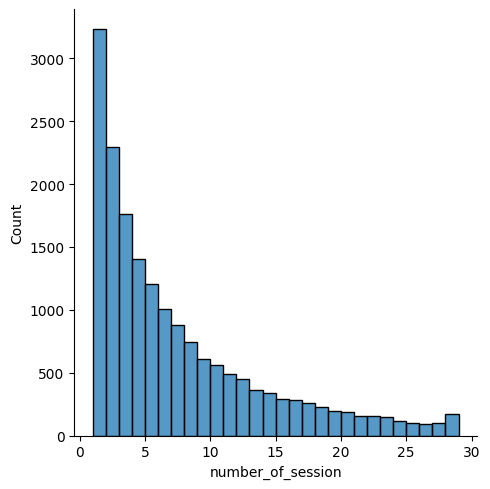

In [9]:
#Plot the distribution of the number of session per user per day
sns.displot(remove_outliers(number_of_session, 'number_of_session')['number_of_session'], kde=False, bins=28)

We see that half of the user do not take more than 5 sessions. We consider this fact in our choice of features.

In [10]:
#Create a percentage of math questions per user per session
math_sessions = m4_events.copy()
math_sessions = math_sessions.dropna(subset=['math'])

#We count the number of math questions that a user take per day
math_sessions = math_sessions.groupby(['user_id', 'session_id']) \
                                .math.mean() \
                                .reset_index()[['user_id', 'session_id', 'math']] \
                                .rename(columns={'math': 'math_session'})


<Axes: xlabel='math_session', ylabel='count'>

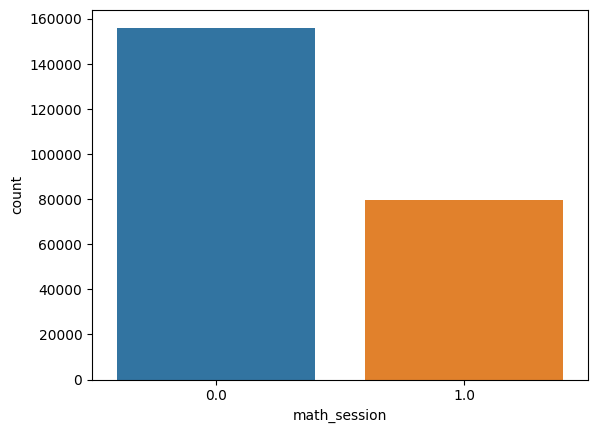

In [11]:
#Print number of point for each category
sns.barplot(x=math_sessions['math_session'].value_counts().index, y=math_sessions['math_session'].value_counts())

There is 2 times more German session than maths one.

In [12]:
#Create a percentage of correct questions per user per session
percentage_of_correct_questions = m4_events.copy()[['user_id', 'session_id', 'transaction_token']]
percentage_of_correct_questions = pd.merge(percentage_of_correct_questions, m4_transactions[['transaction_token', 'point']], on='transaction_token', how='left')

percentage_of_correct_questions = percentage_of_correct_questions.dropna(subset=['point'])
percentage_of_correct_questions = percentage_of_correct_questions.groupby(['user_id', 'session_id']) \
                                        .point.mean() \
                                        .reset_index()[['user_id', 'session_id', 'point']] \
                                        .rename(columns={'point': 'percentage_of_correct_questions'})
percentage_of_correct_questions['percentage_of_correct_questions'].describe()

count    236278.000000
mean          0.418435
std           0.292387
min           0.000000
25%           0.166667
50%           0.461538
75%           0.625000
max           1.000000
Name: percentage_of_correct_questions, dtype: float64

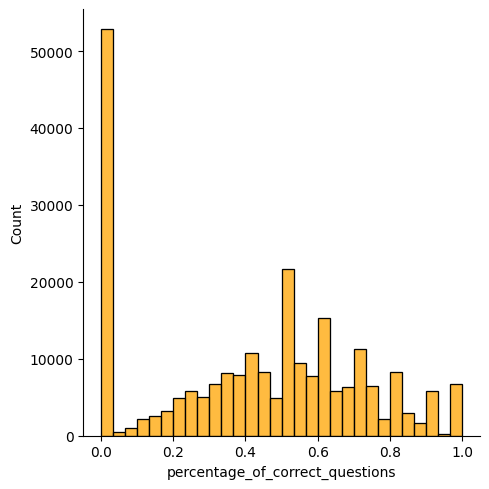

In [13]:
sns.displot(percentage_of_correct_questions['percentage_of_correct_questions'], kde=False, bins=30, color='orange')

We can see that there is a high number of people who do not answer any question right. We will consider this fact in our choice of features. That can potentially say something about the behavior of the users.

In [14]:
#Now we will calculate the difficulty of each question depending of the percentage of correct answer put 0.5 if the number of answer is less than 10
difficulty_of_questions = m4_transactions.copy()[['document_id', 'point']] \
                            .groupby('document_id') \
                            .point \
                            .agg(['count', 'mean']) \
                            .reset_index() \
                            .rename(columns={'count': 'number_of_answers', 'mean': 'difficulty_of_questions'})
         
difficulty_of_questions['difficulty_of_questions'] = difficulty_of_questions.apply(lambda x: 0.5 if x['number_of_answers'] < 6 else x['difficulty_of_questions'], axis=1) #if the number of answer is less than 6 we put 0.5 to avoid outliers

In [15]:
#create the mean of difficulty of questions per user per session
mean_of_difficulty_of_questions = m4_events.copy()[['user_id', 'session_id', 'transaction_token']]

#Merge the dataset to get the right data
mean_of_difficulty_of_questions = pd.merge(mean_of_difficulty_of_questions, m4_transactions[['transaction_token', 'document_id']], on='transaction_token', how='left')
mean_of_difficulty_of_questions = pd.merge(mean_of_difficulty_of_questions, difficulty_of_questions[['document_id', 'difficulty_of_questions']], on='document_id', how='left')

mean_of_difficulty_of_questions = mean_of_difficulty_of_questions.dropna(subset=['difficulty_of_questions'])

#We calculate the mean of difficulty of questions per user per day
mean_of_difficulty_of_questions = mean_of_difficulty_of_questions.groupby(['user_id', 'session_id']) \
                                        .difficulty_of_questions.mean() \
                                        .reset_index()[['user_id', 'session_id', 'difficulty_of_questions']] \
                                        .rename(columns={'difficulty_of_questions': 'mean_of_difficulty_of_questions'})
mean_of_difficulty_of_questions['mean_of_difficulty_of_questions'].describe()

count    236278.000000
mean          0.441266
std           0.108473
min           0.000000
25%           0.373068
50%           0.442113
75%           0.507797
max           0.938338
Name: mean_of_difficulty_of_questions, dtype: float64

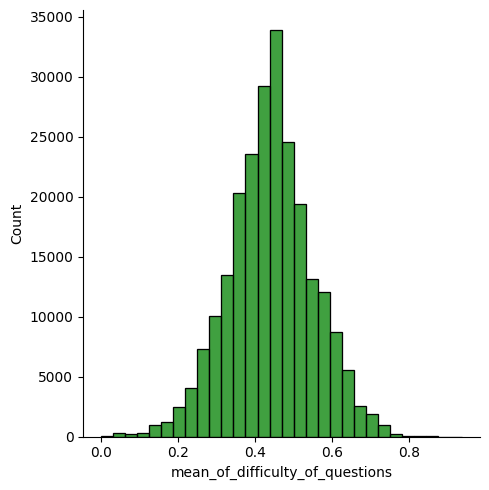

In [16]:
sns.displot(mean_of_difficulty_of_questions['mean_of_difficulty_of_questions'], kde=False, bins=30, color='green')

The question are in the average answered less than 50% of the time. Thus, the questions are generally relatively hard. Also we do not observe many point after 70% of correct answer. We will consider this fact in our choice of features.

In [17]:
#create duration of session per user per session
duration_of_session = m4_events.copy()[['user_id', 'session_id', 'transaction_token']]
duration_of_session = pd.merge(duration_of_session, m4_transactions[['transaction_token', 'start_time', 'commit_time', 'session_closed']], on='transaction_token', how='left')

session_not_closed = duration_of_session[duration_of_session['session_closed'] == 0] #We take only the session that are not closed
session_closed = duration_of_session[duration_of_session['session_closed'] == 1] #We take only the session that are not closed
#Select one row per session and calculate the duration of the session
session_not_closed = session_not_closed[['user_id', 'session_id', 'session_closed','start_time']]
session_not_closed = session_not_closed.drop_duplicates()
session_not_closed['duration_of_session'] = 0
                                
session_closed = session_closed.dropna(subset=['start_time', 'commit_time']) \
                                .groupby(['user_id', 'session_id', 'session_closed']) \
                                .agg({'start_time': 'min', 'commit_time': 'max'}) \
                                .reset_index()

session_closed['duration_of_session'] = session_closed['commit_time'] - session_closed['start_time'] #Calculate the duration of the session
session_closed = session_closed[['user_id', 'session_id','session_closed', 'start_time', 'duration_of_session']]
duration_of_session = pd.concat([session_closed, session_not_closed]) #Concat the two dataset

count                       212904
mean     0 days 00:03:26.702732654
std      0 days 00:03:42.754437686
min                0 days 00:00:00
25%      0 days 00:00:11.471000064
50%      0 days 00:02:26.166000096
75%      0 days 00:05:05.041500032
max      0 days 00:16:54.009000128
Name: duration_of_session, dtype: object


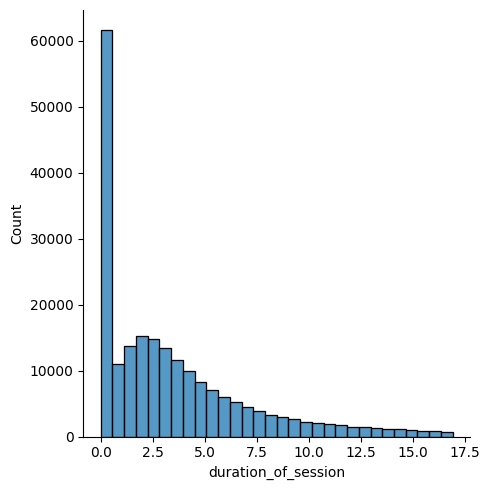

In [18]:
duration_of_session['duration_of_session'] = pd.to_timedelta(duration_of_session['duration_of_session']) #Convert the duration of session to timedelta
print((remove_outliers(duration_of_session,'duration_of_session')['duration_of_session']).describe())
sns.displot(remove_outliers(duration_of_session,'duration_of_session')['duration_of_session'].dt.total_seconds() / 60, kde=False, bins=30)

In [19]:
#We are going to count the number of action per session per day
df_action_per_user_per_session = m4_events.copy()

df_action_per_user_per_session = df_action_per_user_per_session.groupby(['user_id', 'session_id', 'action']).count().reset_index()[['user_id', 'session_id', 'action', 'transaction_token']]

#for each of the different type of action we will create a column with the number of action per day per user
df_action_per_user_per_session = df_action_per_user_per_session.pivot(index=['user_id', 'session_id'], columns='action', values='transaction_token').reset_index()

df_action_per_user_per_session = df_action_per_user_per_session.fillna(0)
df_action_per_user_per_session.describe()

action,user_id,session_id,CLOSE,CLOSE_FEEDBACK,GO_TO_BUG_REPORT,GO_TO_COMMENTS,GO_TO_THEORY,NEXT,OPEN_FEEDBACK,REQUEST_HINT,REVIEW_TASK,SHARE,SKIP,SUBMIT_ANSWER,VIEW_QUESTION
count,236278.000000,236278.000000,236278.000000,236278.000000,236278.000000,236278.000000,236278.000000,236278.000000,236278.000000,236278.000000,236278.000000,236278.000000,236278.000000,236278.000000,236278.000000
mean,404639.224388,157818.029038,0.500686,0.998150,0.028039,0.032347,0.058385,2.396017,1.118737,0.001574,5.656646,0.000288,0.566363,4.447062,1.391137
std,10980.086657,74360.308435,0.581973,2.398074,0.197167,0.240478,0.277079,2.327540,2.583411,0.050031,6.176142,0.018167,2.612717,5.484764,4.722500
min,387604.000000,5812.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,395093.000000,94147.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000
50%,402098.000000,153822.500000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,5.000000,0.000000,0.000000,5.000000,0.000000
75%,411642.000000,221214.750000,1.000000,1.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,5.000000,0.000000,0.000000,5.000000,0.000000
max,432020.000000,298935.000000,45.000000,151.000000,14.000000,67.000000,7.000000,156.000000,152.000000,5.000000,151.000000,2.000000,122.000000,151.000000,426.000000


There are many actions that pratically didn't happen (GO_TO_BUG_REPORT, GO_TO_COMMENTS, GO_TO_THEORY, REQUEST_HINT, SHARE, SKIP, VIEW_QUESTION). We will note that for ou chose of features.

Now that we have all our feature we are going to merge all to get our dataset

## Selection of features

In [20]:
df_session_of_users = df_action_per_user_per_session.copy() \
                        .merge(mean_of_difficulty_of_questions, on=['user_id', 'session_id'], how='left') \
                        .merge(percentage_of_correct_questions, on=['user_id', 'session_id'], how='left') \
                        .merge(duration_of_session, on=['user_id', 'session_id'], how='left') \
                        .merge(math_sessions, on=['user_id', 'session_id'], how='left') 
df_session_of_users.dropna(inplace=True)

In [21]:
#We take only the users with more than 10 sessions
more_10_users = df_session_of_users.copy()[['user_id', 'session_id']] \
                .drop_duplicates() \
                .groupby('user_id') \
                .count() \
                .reset_index() \
                .rename(columns={'session_id': 'number_of_sessions'}) \
                .query('number_of_sessions >= 10')

df_session_plus_10 = df_session_of_users.copy().merge(more_10_users, on='user_id', how='inner')

In our choose of feature, we are going to look at the last sessions of user and see if there is a correlation over the time. To do that we will qualify the last sessions as 1 and the go over by incremented by 1. Thus, if a user has 13 sessions his first one will be labeled with a 13.

In [22]:
user_session_start_time = df_session_plus_10.copy()[['user_id', 'session_id', 'start_time']]
#Sort the dataset by user_id and start_time descending
user_session_start_time = user_session_start_time.sort_values(['user_id', 'start_time'], ascending=[True, False])
user_session_start_time['session_index'] = user_session_start_time.groupby(['user_id']).cumcount() + 1 #Create a session index for each user

In [23]:
df_session_plus_10 = df_session_plus_10.merge(user_session_start_time, on=['user_id', 'session_id', 'start_time'], how='left')
#Run a linear regression to predict the session index
#Drop start_time, user_id session_id columns
df_session_plus_10_regression = df_session_plus_10.drop(['start_time', 'user_id', 'session_id', 'number_of_sessions'], axis=1)
#Change to minutes the duration of session
df_session_plus_10_regression['duration_of_session'] = df_session_plus_10_regression['duration_of_session'].dt.total_seconds() / 60
#drop the rows with null values
df_session_plus_10_regression = df_session_plus_10_regression.dropna()
df_session_plus_10_regression.dropna(inplace=True)

# Separate the predictor variables from the target variable
X = df_session_plus_10_regression.iloc[:, :-1]
#Normalize the data
X = (X - X.mean()) / X.std()
print(X.describe())
y = df_session_plus_10_regression.iloc[:, -1]

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary statistics of the model
print(model.summary())

              CLOSE  CLOSE_FEEDBACK  GO_TO_BUG_REPORT  GO_TO_COMMENTS   
count  1.638720e+05    1.638720e+05      1.638720e+05    1.638720e+05  \
mean   3.738141e-17   -2.714312e-17      3.051433e-18    3.106717e-17   
std    1.000000e+00    1.000000e+00      1.000000e+00    1.000000e+00   
min   -6.715971e-01   -4.786508e-01     -1.366685e-01   -9.764325e-02   
25%   -6.715971e-01   -4.786508e-01     -1.366685e-01   -9.764325e-02   
50%   -6.715971e-01   -4.786508e-01     -1.366685e-01   -9.764325e-02   
75%    1.140620e+00   -8.381811e-02     -1.366685e-01   -9.764325e-02   
max    8.087818e+01    2.479064e+01      5.180243e+01    2.237626e+02   

       GO_TO_THEORY          NEXT  OPEN_FEEDBACK  REQUEST_HINT   REVIEW_TASK   
count  1.638720e+05  1.638720e+05   1.638720e+05  1.638720e+05  1.638720e+05  \
mean   2.132209e-17  9.224759e-18   3.037341e-17 -1.753355e-17 -7.954322e-17   
std    1.000000e+00  1.000000e+00   1.000000e+00  1.000000e+00  1.000000e+00   
min   -2.074399e-01 -1

With this first regression we can easily see the factor that have no link with the evolution of session. We are going to take the features with p value less than 0.05.

In [24]:
selected_columns = ['CLOSE', 'GO_TO_BUG_REPORT','GO_TO_THEORY','NEXT','VIEW_QUESTION','mean_of_difficulty_of_questions','session_closed','duration_of_session','math_session']

## Creation of the Dataset

Now we are going to create our dataset. We are going to take batch of 5 consecutives sessions and create a dataset with the features we have selected. By this we will have the evolution of each users. Our y will be the number of session the user is going to do after the batch of 5 sessions.
To save us time we are going to take the last 10 sessions of each user in such a way to have consitent data.

In [25]:
#Get the last index of each user
last_session_per_user = df_session_plus_10.copy() \
                        .groupby('user_id') \
                        .agg({'session_index': 'max'}) \
                        .reset_index() \
                        .rename(columns={'session_index': 'last_session_index'})
                        
#Merge the last session index with the dataset
df_session_plus_10 = df_session_plus_10.copy().merge(last_session_per_user, on='user_id', how='left')

#For each user take the first 10 sessions
df_session_first_10 = df_session_plus_10.copy()[df_session_plus_10['session_index'] <= 10]
#Take selected columns, user_id 
df_session_first_10 = df_session_first_10.copy()[['user_id', 'session_index', 'last_session_index'] + selected_columns]
df_session_first_10.sort_values(['user_id', 'session_index'], inplace=True)

In [26]:
#replace session_index with the number of session from the last session
df_session_first_10.dropna(inplace=True)
df_session_first_10.drop('last_session_index', axis=1, inplace=True)
df_session_first_10['duration_of_session'] = df_session_first_10['duration_of_session'].dt.total_seconds() / 60

In [27]:
time_series = df_session_first_10.pivot(index='user_id', columns='session_index')
time_series

CLOSE                                               ...   
session_index    1    2    3    4    5    6    7    8    9    10  ...   
user_id                                                           ...   
387604          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  \
387605          0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   
387608          0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  ...   
387650          1.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  ...   
387666          0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  ...   
...             ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
431855          0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   
431856          0.0  0.0  1.0  1.0  1.0  2.0  0.0  1.0  1.0  0.0  ...   
431861          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
431864          0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  2.0  ...   
431896          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

              math_session                                               
session_index           1    2    3    4    5    6    7    8    9    10  
user_id                                                                  
387604                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
387605                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  
387608                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
387650                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
387666                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
...                    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
431855                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
431856                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
431861                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
431864                 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
431896                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5441 rows x 90 columns]

In [29]:
#Fonction that create the Dataframe of omega number of consecutive sessions
def creation_df(omega = 5):
    columns = []
    for column in time_series.columns.levels[0]:
        for j in range(1, omega + 1):
            columns.append(column + '_' + str(j))
            
    times_series_consecutive_sessions = []

    for k in range(0, 11 - omega):
        tab = [i+j for j in range(0 + k, len(time_series.columns),10) for i in range(0, omega)]
        data = time_series.copy().iloc[:, tab]
        #rename columns
        data.columns = columns
        #Add a column y 
        data.reset_index(inplace=True)
        data = data.merge(last_session_per_user, on='user_id', how='left')
        data['y'] = data['last_session_index'] - (omega + k)
        data.drop('last_session_index', axis=1, inplace=True)
        times_series_consecutive_sessions.append(data)

    df = pd.concat(times_series_consecutive_sessions, axis=0)
    #shifted logarithm y column
    df['y'] = np.log(df['y'] + 1)
    return df

In [67]:
df = creation_df(omega=5)
print(df)

      user_id  CLOSE_1  CLOSE_2  CLOSE_3  CLOSE_4  CLOSE_5   
0      387604      0.0      0.0      0.0      0.0      0.0  \
1      387605      0.0      0.0      0.0      1.0      1.0   
2      387608      0.0      0.0      0.0      0.0      1.0   
3      387650      1.0      1.0      1.0      1.0      0.0   
4      387666      0.0      0.0      0.0      0.0      1.0   
...       ...      ...      ...      ...      ...      ...   
5436   431855      0.0      0.0      1.0      0.0      0.0   
5437   431856      2.0      0.0      1.0      1.0      0.0   
5438   431861      0.0      0.0      0.0      0.0      0.0   
5439   431864      1.0      1.0      0.0      1.0      2.0   
5440   431896      0.0      0.0      0.0      0.0      0.0   

      GO_TO_BUG_REPORT_1  GO_TO_BUG_REPORT_2  GO_TO_BUG_REPORT_3   
0                    1.0                 1.0                 1.0  \
1                    0.0                 0.0                 0.0   
2                    0.0                 0.0       

Thus we have our dataframe constructed with the time series of 5 consecutives sessions and the number of session after the batch of 5 sessions which is the y

## MODELS

Because nothing suceed in the first milestone, we are going to compare two new models in this M7 this first one is a linear regression. The second one is a CNN. 
Also we are going to see which parameter omega of the time series is the more efficient to predict future value.

### Linear Regression

In [69]:
def linear_regression(normalizeX, omega):
    df = creation_df(omega=5)
    df = df.sample(frac=1).reset_index(drop=True)

    y = df['y']
    X = df.drop('y', axis=1)
    
    if normalizeX:
        X = (X - X.mean()) / X.std()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    model = LinearRegression()
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    #return MSE, MAE and R2
    return mean_squared_error(y_test, predictions), mean_absolute_error(y_test, predictions), r2_score(y_test, predictions)

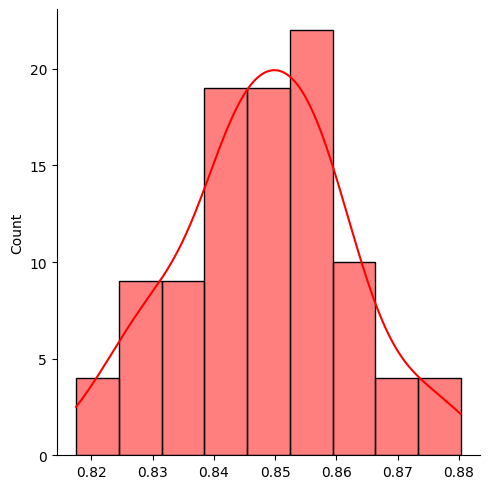

In [70]:
mse = []
mae = []
r2 = []
for i in range(100):
    mse.append(linear_regression(normalizeX=False, omega=5)[0])
    mae.append(linear_regression(normalizeX=False, omega=5)[1])
    r2.append(linear_regression(normalizeX=False, omega=5)[2])
sns.displot(mse,color='red', kde=True)

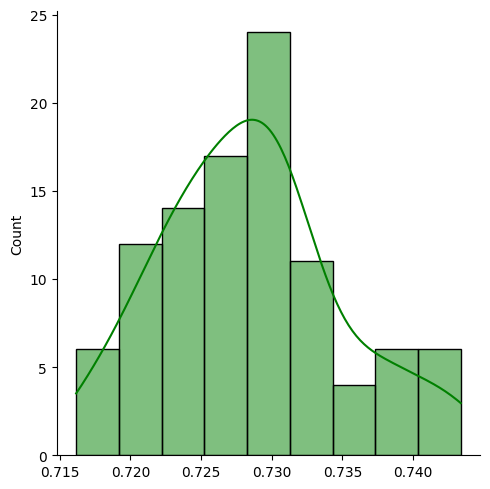

In [71]:
sns.displot(mae,color='green', kde=True)

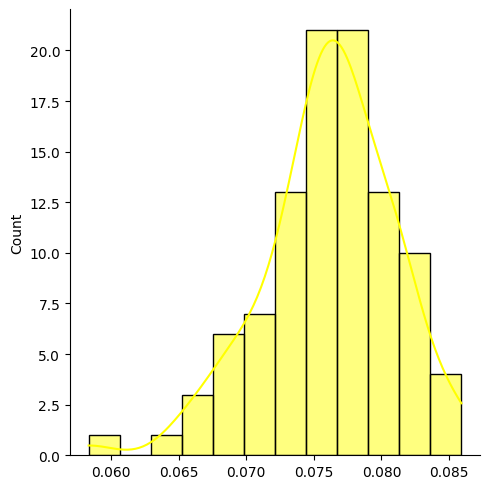

In [72]:
sns.displot(r2,color='yellow', kde=True)

Look at the difference between normalize and non normalize data

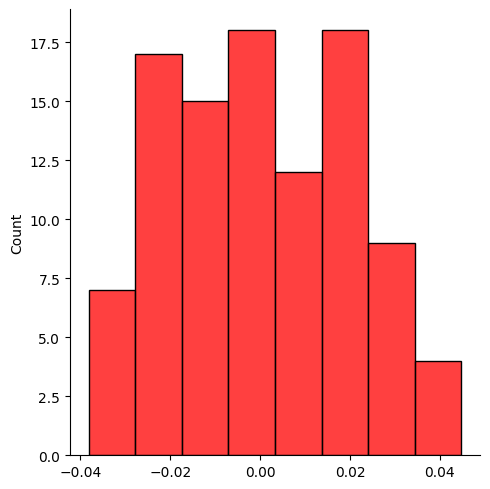

In [73]:
#Run 100 linear regression and compare the difference between MSE
mse = []
mae = []
r2 = []
for j in range(100):
    mse.append(linear_regression(normalizeX=False, omega=5)[0] - linear_regression(normalizeX=True, omega=5)[0])
    mae.append(linear_regression(normalizeX=False, omega=5)[1] - linear_regression(normalizeX=True, omega=5)[1])
    r2.append(linear_regression(normalizeX=False, omega=5)[2] - linear_regression(normalizeX=True, omega=5)[2])
sns.displot(mse, color='red')

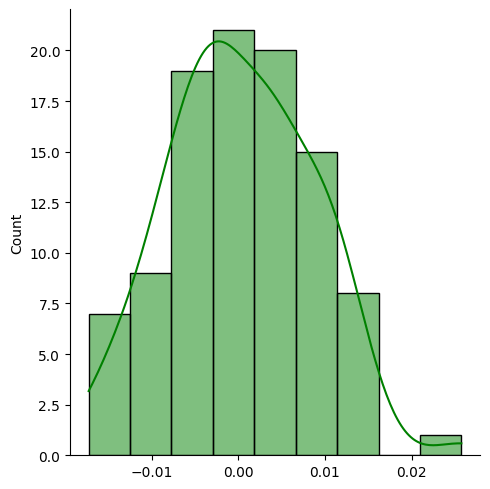

In [74]:
sns.displot(mae,color='green', kde=True)

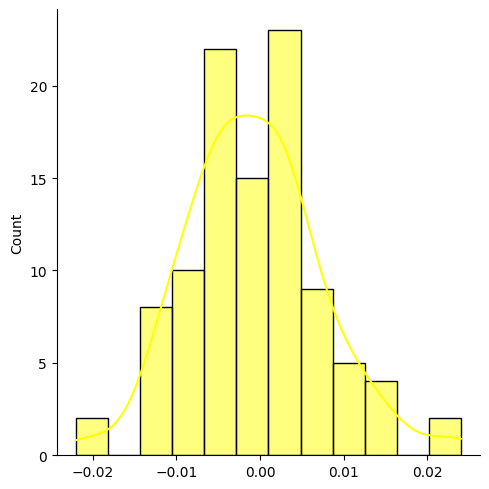

In [75]:
sns.displot(r2,color='yellow', kde=True)

There is no difference between normalize and non normalize data. The MSE is very high. We are going to try to use PCA to see if there is a difference.

In [78]:
def PCA_linear_regression(omega=5, n_components = 10):
    df = creation_df(omega=omega)
    df = df.sample(frac=1).reset_index(drop=True)

    y = df['y']
    X = df.drop('y', axis=1)
        
    pca = PCA(n_components=n_components)
    pca.fit(X)
    X = pca.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    model = LinearRegression()
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    return mean_squared_error(y_test, predictions), mean_absolute_error(y_test, predictions), r2_score(y_test, predictions)

In [97]:
#We are going to find the best number of components for PCA
mse_all = []
mae_all = []
r2_all = []
for i in range(15, 30):
    mse = []
    mae = []
    r2 = []
    for j in range(20):
        mse.append(PCA_linear_regression(omega=5, n_components = i)[0])
        mae.append(PCA_linear_regression(omega=5, n_components = i)[1])
        r2.append(PCA_linear_regression(omega=5, n_components = i)[2])
    mse_all.append(np.mean(mse))
    mae_all.append(np.mean(mae))
    r2_all.append(np.mean(r2))

<Axes: >

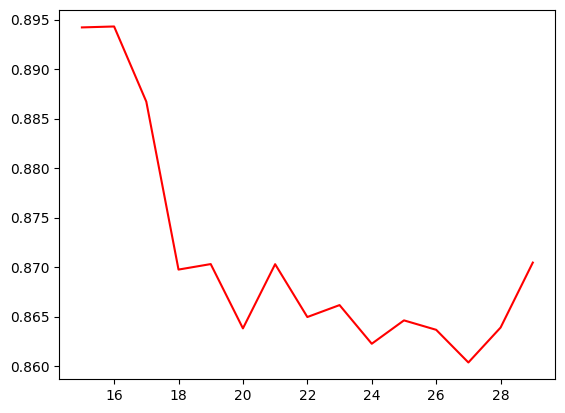

In [98]:
sns.lineplot(x=range(15, 30), y=mse_all, color = 'red')

<Axes: >

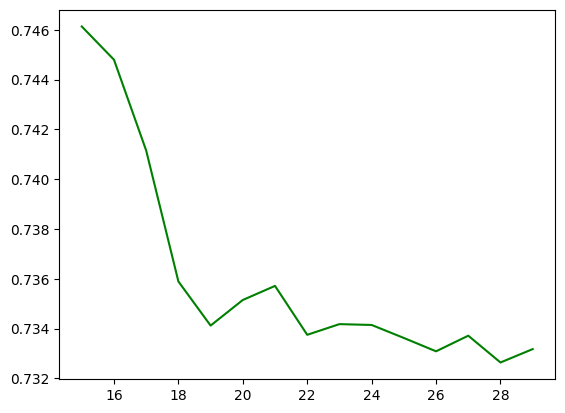

In [99]:
sns.lineplot(x=range(15, 30), y=mae_all, color = 'green')


<Axes: >

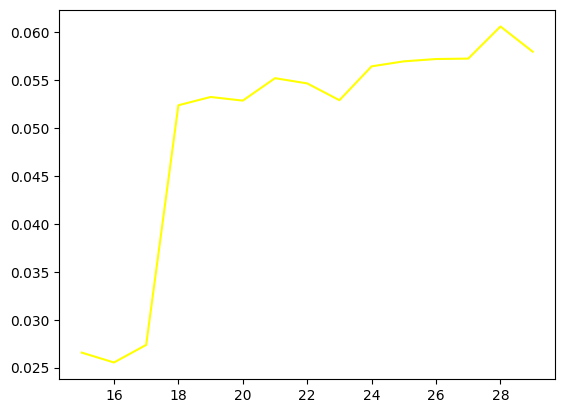

In [100]:
sns.lineplot(x=range(15, 30), y=r2_all, color = 'yellow')


PCA doesn't work better than a simple linear regression this means that our data is not linearly separable. 

<Axes: >

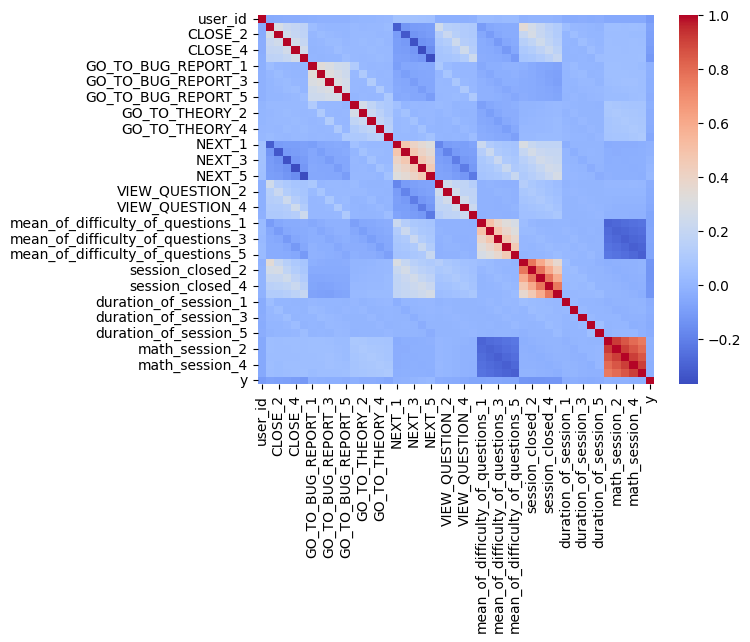

In [82]:
df = creation_df(omega=5)
sns.heatmap(df.corr(), annot=False, cmap='coolwarm' )

In fact there is no many correlation between variables in our time series unless variable of the same type PCA is not efficient for ou dataset.

We are going to find another model to resovle our problem but first we want to see if there is value of omega that can reveal more information about the evolution of the user. 

<Axes: >

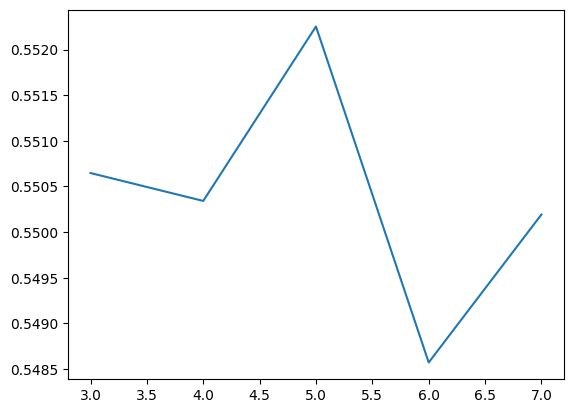

In [83]:
mse_all = []
for i in range(3,8):
    MSE = []
    for j in range(30):
        MSE.append(linear_regression(normalizeX=True, omega=i))
    mse_all.append(np.mean(MSE))
sns.lineplot(x=range(3,8), y=mse_all)

Nothing with Omega also. We are trying to see if CNN can work here and if not we will change our strategy and look at other features or structure of the dataset.

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Assuming you have your input data in X and output data in y
# Split the data into training and testing sets
def my_cnn(first_layer_size = 64 , second_layer_size = 64):
    omega = 3
    input_size = 9 * omega + 1
    df = creation_df(omega=omega)
    batch_size = 12

    X = df.drop('y', axis=1).values
    y = df['y'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    # Convert the data to PyTorch tensors
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()

    # Create a PyTorch DataLoader for your dataset
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=first_layer_size, shuffle=True)

    # Define the neural network model
    class NeuralNetwork(nn.Module):
        def __init__(self, input_size,first_layer_size,second_layer_size):
            super(NeuralNetwork, self).__init__()
            self.fc1 = nn.Linear(input_size, first_layer_size)
            self.fc2 = nn.Linear(first_layer_size, second_layer_size)
            self.fc3 = nn.Linear(second_layer_size, 1)

        def forward(self, x):
            x = nn.functional.relu(self.fc1(x))
            x = nn.functional.relu(self.fc2(x))
            x = self.fc3(x)
            return x.squeeze()

    # Create an instance of your neural network model
    model = NeuralNetwork(input_size=input_size, first_layer_size=first_layer_size, second_layer_size=second_layer_size)

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    for _ in range(10):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model on the test set
    with torch.no_grad():
        y_pred = model(X_test)
        loss = criterion(y_pred, y_test)

    
    # Set the model to evaluation mode
    model.eval()

    # Evaluate the model on the test set
    with torch.no_grad():
        y_pred = model(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

    return mse, mae, r2

We are going to perform a grid search to find the best parameters for our CNN


In [85]:
first_layer_size = [8, 16, 32, 64]
second_layer_size = [8, 16, 32, 64]
mse_results = []
mae_results = []
r2_results = []
for j in first_layer_size:
    for k in second_layer_size:
        mse_results.append([j, k ,my_cnn(first_layer_size=j, second_layer_size=k)[0]])
        mae_results.append([j, k ,my_cnn(first_layer_size=j, second_layer_size=k)[1]])
        r2_results.append([j, k ,my_cnn(first_layer_size=j, second_layer_size=k)[2]])

Text(50.722222222222214, 0.5, 'First Layer Size')

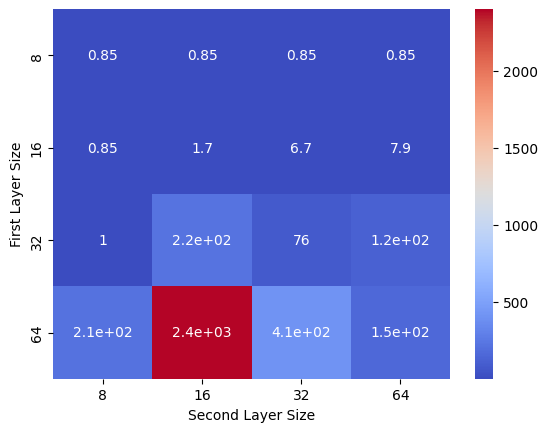

In [86]:
sns.heatmap(pd.DataFrame(mse_results).pivot(index=0, columns=1, values=2), annot=True, cmap='coolwarm')
#rename column first and second layer
plt.xlabel('Second Layer Size')
plt.ylabel('First Layer Size')

Text(50.722222222222214, 0.5, 'First Layer Size')

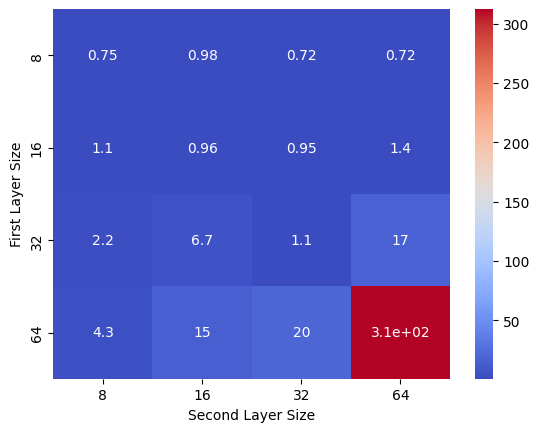

In [87]:
sns.heatmap(pd.DataFrame(mae_results).pivot(index=0, columns=1, values=2), annot=True, cmap='coolwarm')
#rename column first and second layer
plt.xlabel('Second Layer Size')
plt.ylabel('First Layer Size')

Text(50.722222222222214, 0.5, 'First Layer Size')

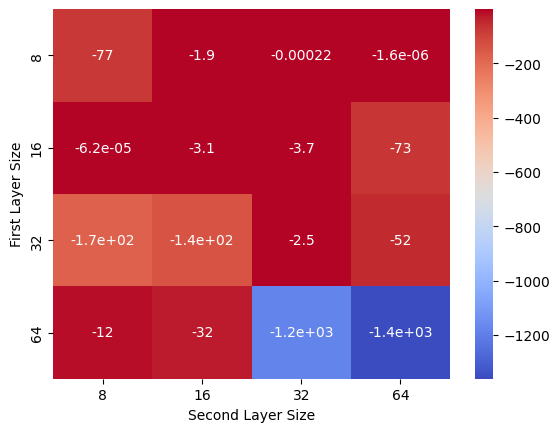

In [88]:
sns.heatmap(pd.DataFrame(r2_results).pivot(index=0, columns=1, values=2), annot=True, cmap='coolwarm')
#rename column first and second layer
plt.xlabel('Second Layer Size')
plt.ylabel('First Layer Size')

We didn't suceed to outperform the linear regression our best MSE is 0.84 in both models

Now we are going to use a LSTM which is more feat for this type of case.

In [89]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Define the LSTM network architecture

def my_lstm(hidden_size, n_episode):
    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(LSTMModel, self).__init__()
            self.hidden_size = hidden_size
            self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            _, (hidden_state, _) = self.lstm(x)
            hidden_state = hidden_state[-1]
            output = self.fc(hidden_state)
            output = self.sigmoid(output)
            return output

    # Load the dataset
    df = creation_df(omega=5)

    X = df.drop('y', axis=1).values
    y = df['y'].values

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert the data to PyTorch tensors
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()

    # Reshape the input data into 3D shape (samples, time steps, features)
    X_train = X_train.view(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.view(X_test.shape[0], 1, X_test.shape[1])

    # Define the model, loss function, and optimizer
    input_size = X_train.shape[2]
    hidden_size = 64
    output_size = 1
    model = LSTMModel(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = n_episode
    for _ in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    
        # Evaluate the model on the test set
    with torch.no_grad():
        y_pred = model(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

    return mse, mae, r2

In [92]:
layer_size = [8, 16, 32, 64, 128, 256]
n_episode = [10, 50, 100, 200, 500, 1000]
MSE = []
MAE = []
R2 = []
for i in layer_size:
    for j in n_episode:
        MSE.append([i, j, my_lstm(hidden_size=i, n_episode=j)[0]])
        MAE.append([i, j, my_lstm(hidden_size=i, n_episode=j)[1]])
        R2.append([i, j, my_lstm(hidden_size=i, n_episode=j)[2]])

Text(50.722222222222214, 0.5, 'Hidden Layer Size')

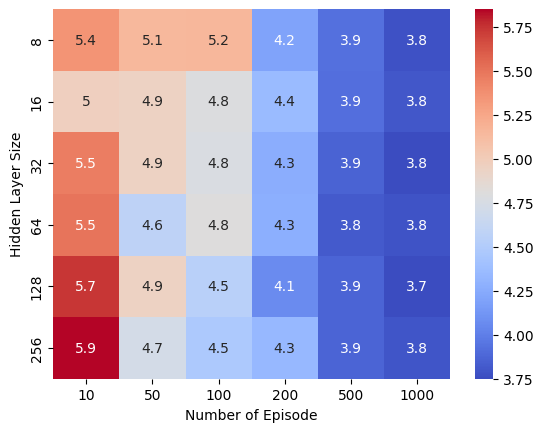

In [101]:
MSE_df = pd.DataFrame(MSE)
pivot_table = MSE_df.pivot(index=0, columns=1, values=2).astype(float)

sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.xlabel('Number of Episode')
plt.ylabel('Hidden Layer Size')

Text(50.722222222222214, 0.5, 'Hidden Layer Size')

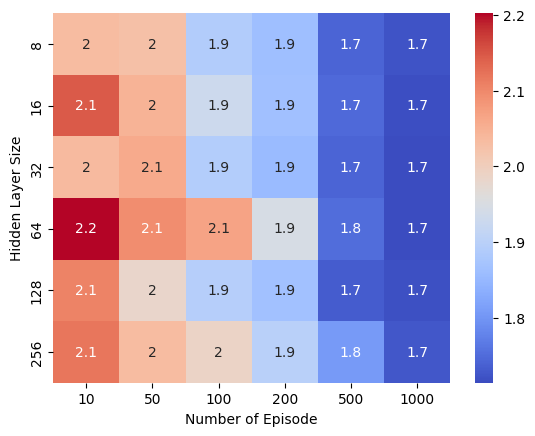

In [102]:
MAE_df = pd.DataFrame(MAE)
pivot_table = MAE_df.pivot(index=0, columns=1, values=2).astype(float)

sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.xlabel('Number of Episode')
plt.ylabel('Hidden Layer Size')

Text(50.722222222222214, 0.5, 'Hidden Layer Size')

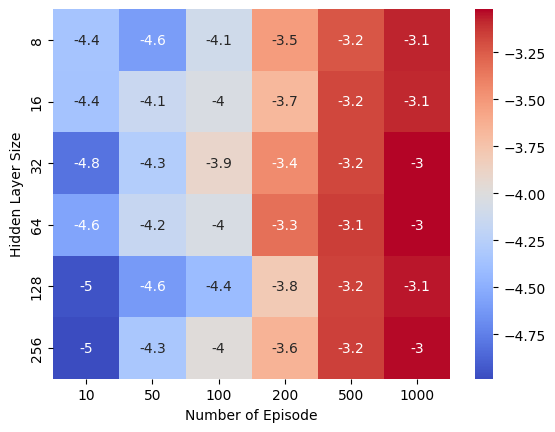

In [103]:
R2_df = pd.DataFrame(R2)
pivot_table = R2_df.pivot(index=0, columns=1, values=2).astype(float)

sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.xlabel('Number of Episode')
plt.ylabel('Hidden Layer Size')